# Transfer Learning

In [27]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

import json, sys, os
from utils import checkLocalServer, Config_Manager

cfgm = Config_Manager()
cfgm.set_cfg_path('./configs/config_train_unregistered.json')
cfg = cfgm.get_cfg()
cfgm.print()

checkLocalServer(cfg['isLocalServer'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Volumes/ssd/code/FaceID-model
{'isLocalServer': False, 'sys_path_to_be_added': './data', 'path_for_saving_model': './data/face-extraction-model.pt', 'selected_data': {'data_path': './data/photos_cropped_test/selected_data', 'save_path_dataloader': './data/data_loader.pth', 'train_ratio': 0.8, 'val_ratio': 0.1, 'batch_size': 2, 'image_size': 250, 'image_rotation_angle': 10, 'isTransformer': True}, 'unselected_data': {'data_path': './data/photos_cropped_test/unselected_data/', 'save_path_dataloader': './data/data_loader.pth', 'batch_size': 2, 'image_size': 250, 'image_rotation_angle': 10, 'isTransformer': True}, 'model': {'pretrained': 'vggface2', 'num_classes': 4, 'classify': True, 'image_size': 250}}
isLocalServer is False


image size: 250
0 jhoh
1 jhongyoo
2 jhyoo
batch_size: 2 

dataset length: (15) = tr (12) + val (1) + tt (2)
image dimension: (3, 250, 250)


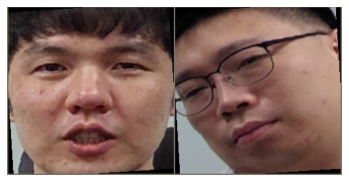

input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 0
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 1


In [30]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

folder_Dataset = Folder_Dataset(cfg['selected_data'])

dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

# show a example picture 
image_size = imshow_dataloader(dataloaders["train"])

phase="train"
for i, (inputs, labels) in enumerate(dataloaders[phase]):
  if i > 3:
    break
  print(f'input shape: {inputs[0].shape} / label shape: {labels[0].shape} / label: {labels[0]}')
  

# Train model

In [13]:
from modules import Builder
import torch.nn as nn
import torch.optim as optim

builder = Builder(cfg['model'])
builder.summary()
model = builder.getModel()

# declaration for learning and testing|
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device is cpu
Loading model was just completed.
InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_st

In [16]:
from modules import runner
phases = ['train', 'val']

model, train_evaluation_matrix, val_evaluation_matrix = runner(model,
                                                               phases,
                                                               criterion,
                                                               optimizer,
                                                               scheduler,
                                                               dataloaders,
                                                               dataset_sizes,
                                                               num_epochs=10)

Epoch 0/29
[phase]:train
train Loss: 0.0498 Acc: 1.0000 recall: 1.0000 Precision: 1.0000
[phase]:val
val Loss: 0.0243 Acc: 1.0000 recall: 1.0000 Precision: 1.0000
----------------------------------------------------------------------------------------------------
Epoch 1/29
[phase]:train
train Loss: 0.5552 Acc: 0.7500 recall: 0.7833 Precision: 0.7833
[phase]:val
val Loss: 0.0203 Acc: 1.0000 recall: 0.7833 Precision: 0.8056
----------------------------------------------------------------------------------------------------
Epoch 2/29
[phase]:train
train Loss: 0.2986 Acc: 0.8333 recall: 0.8667 Precision: 0.8500
[phase]:val
val Loss: 0.0345 Acc: 1.0000 recall: 0.8667 Precision: 0.8667
----------------------------------------------------------------------------------------------------
Epoch 3/29
[phase]:train
train Loss: 0.2905 Acc: 0.9167 recall: 0.9333 Precision: 0.9167
[phase]:val
val Loss: 0.0468 Acc: 1.0000 recall: 0.9333 Precision: 0.9333
---------------------------------------------

30 4


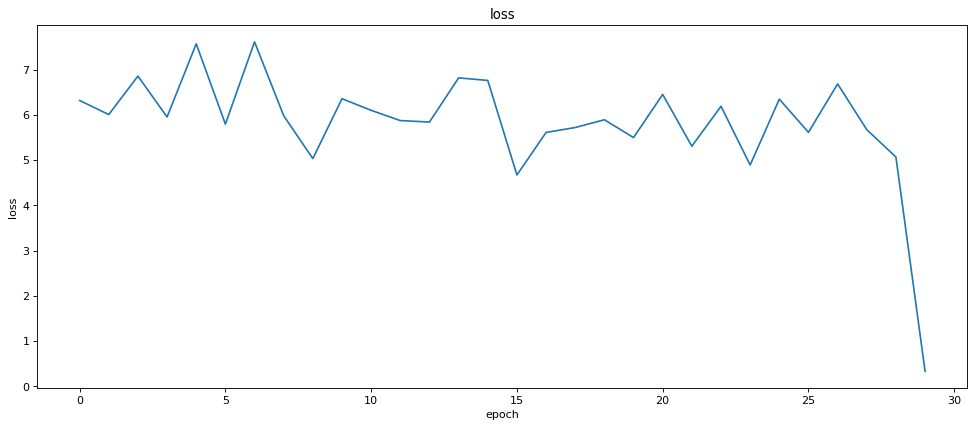

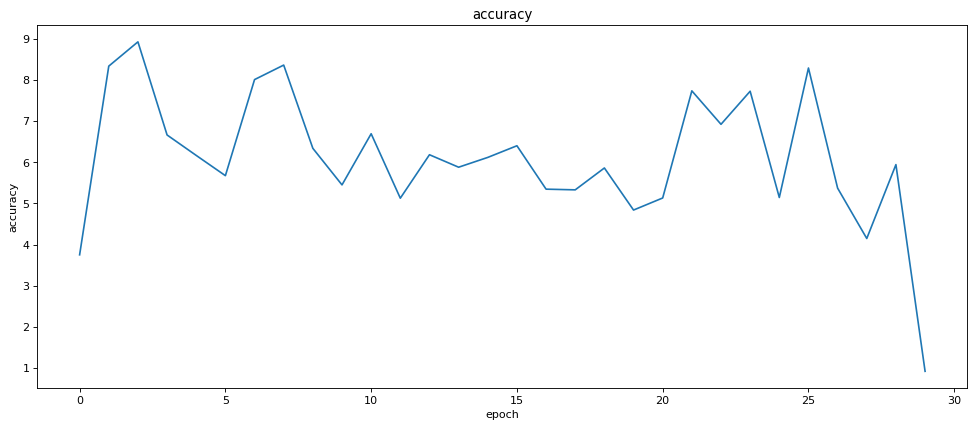

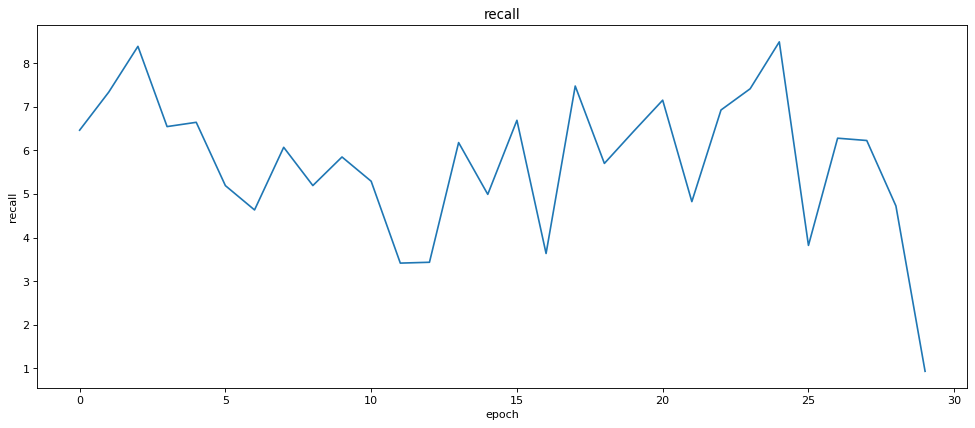

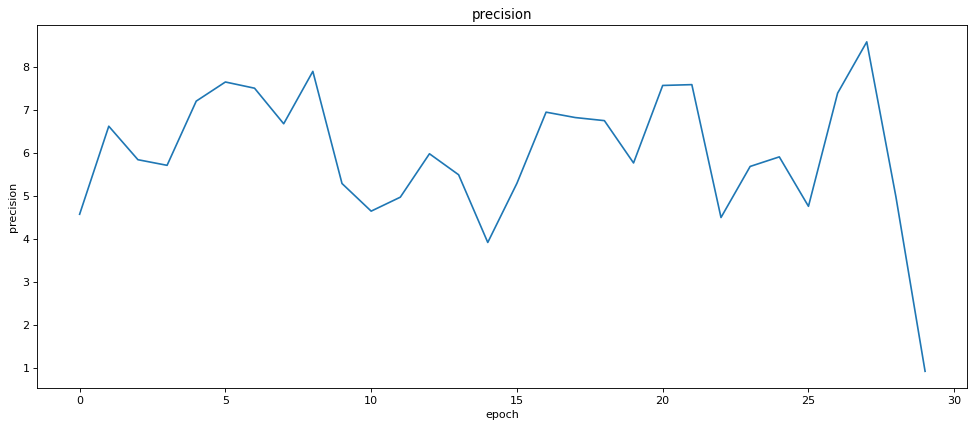

In [17]:
import matplotlib.pyplot as plt
train_evaluation_numpy = train_evaluation_matrix.to('cpu').numpy()
val_evaluation_numpy = val_evaluation_matrix.to('cpu').numpy()

num_epochs, num_evaluations = train_evaluation_numpy.shape
print(num_epochs, num_evaluations)

title_list = ['loss', 'accuracy', 'recall', 'precision']
for col, title in zip(range(0, num_evaluations), title_list):
  plt.figure(figsize=(15, 6), dpi=80)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.plot(range(0, num_epochs), train_evaluation_numpy[:, col])
  plt.show()

In [18]:
phases = ['test']
runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)

Epoch 0/0
[phase]:test
test Loss: 0.0184 Acc: 1.0000 recall: 1.0000 Precision: 1.0000
----------------------------------------------------------------------------------------------------
Training complete in 0m 1s
Best val Acc: 0.000000
there is no return value becasue of test mode


## Save trained model

In [19]:
import torch
cfg = cfgm.get_cfg()
path_for_saving_model = cfg['path_for_saving_model']

try: 
  torch.save(model.state_dict(), path_for_saving_model)
  print(f'successfully saved model in {path_for_saving_model}')
except:
  print(f'failed saving model in {path_for_saving_model}')

successfully saved model in ./data/face-extraction-model.pt


# After train

In [34]:
folder_Dataset.setIsSplit(False)
dataloaders, dataset_sizes = folder_Dataset.createDataLoaders()

In [67]:
phases = ['test']
prob = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)
print(prob)

Epoch 0/0
[phase]:test
test Loss: 0.0235 Acc: 1.0000 recall: 1.0000 Precision: 1.0000 avg_prob: 0.9823
----------------------------------------------------------------------------------------------------
Training complete in 0m 4s
Best val Acc: 0.000000
there is no return value becasue of test mode
tensor(0.9823)


In [43]:
import numpy as np
threshold_list = np.arange(0, 1, 0.1)


for threshold in threshold_list:
    threshold = np.round(threshold, 2)
    
    print(threshold)
    prob = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, threshold=threshold, num_epochs=1)
    

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
